# Predicting S&P 500 Recession Trends with Machine Learning

## Refined Problem Statement

This project aims to build a simple and robust model to predict recession trends proxied by performance of the US S&P 500 purely based on publicly released economic data. The project is going to use and is not limited to the following data: consumer price index, industrial production index, unemployment rate, new private housing building permits, mortgage rates, median home value, credit discount rate, commercial and industrial loan rates, federal monetary fund rate, household savings rate, disposable personal income, and commodity indicators such as motor vehicle sales.

In [1]:
# Import Necessary Libraries 
import ta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.tsa.api as smt
import pandas_datareader.data as web
import warnings

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, pacf, adfuller
from arch import arch_model
from pmdarima.arima import auto_arima

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

from matplotlib.ticker import FormatStrFormatter

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

## Exploratory Data Analysis

Before building our learning models, we apply an exploratory data analysis step to understand the data we are working with and preview any obvious and immediate trends present.  This is a good start in seeing which indicators standout or have a particularly eye-catching trend over time, so that we are able to predict which predictor variables or combination of predictor variables prove most effective in predicting the S&P 500 price.

In [3]:
df = pd.read_csv("Data_Storage.csv")

In [4]:
df.head()

,Month,Year,Median Home Values (in thousands of dollars),30-year Fixed Mortgage Rate (%),Private Housing Permits (in thousands),Total Vehicle Sales (in thousands),Discount Rate (%),Personal Savings Rate (%),Real Disposable Personal Income: Per Capita (in thousands of dollars),Industrial Production Index (%),Commercial and Industrial Loans (in thousands of dollars),CPI for All Urban Consumers (%),Seasonally Adjusted Unemployment Rate (%),Federal Funds Effective Rate (%),S&P500 price close at end of the month (^GSPC) (dollars)
0,January,2000,131.59,8.21,107.3,18635.0,5.00,5.0,33.12,91.63,1.003637e+09,168.8,4.0,5.45,1366.42
1,February,2000,131.36,8.33,121.8,19401.0,5.24,4.5,33.22,91.96,1.016649e+09,169.8,4.1,5.73,1498.58
2,March,2000,132.87,8.24,153.7,18343.0,5.34,4.3,33.28,92.31,1.026226e+09,171.2,4.0,5.85,1452.43
3,April,2000,134.13,8.15,138.9,17939.0,5.50,4.8,33.43,92.89,1.035176e+09,171.3,3.8,6.02,1420.60
4,May,2000,135.19,8.52,148.9,17943.0,5.71,4.8,33.54,93.16,1.052021e+09,171.5,4.0,6.27,1454.60


In [5]:
df.describe()

,Year,Median Home Values (in thousands of dollars),30-year Fixed Mortgage Rate (%),Private Housing Permits (in thousands),Total Vehicle Sales (in thousands),Discount Rate (%),Personal Savings Rate (%),Real Disposable Personal Income: Per Capita (in thousands of dollars),Industrial Production Index (%),Commercial and Industrial Loans (in thousands of dollars),CPI for All Urban Consumers (%),Seasonally Adjusted Unemployment Rate (%),Federal Funds Effective Rate (%),S&P500 price close at end of the month (^GSPC) (dollars)
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,2.740000e+02,274.000000,274.000000,274.000000,274.000000
mean,2010.919708,211.508832,4.999599,112.891606,15972.277372,2.055803,6.589416,39.742883,96.866387,1.585621e+09,222.487883,5.874088,1.627701,1869.658942
std,6.602318,55.185358,1.359377,40.758249,2303.110509,1.848557,3.519511,4.152962,4.979046,5.722904e+08,30.860229,1.956960,1.863905,962.211589
min,2000.000000,131.360000,2.680000,36.300000,8923.000000,0.250000,2.100000,33.120000,84.730000,8.628414e+08,168.800000,3.500000,0.050000,735.090000
25%,2005.000000,177.337500,3.900000,83.575000,14784.250000,0.750000,4.800000,36.685000,92.802500,1.081409e+09,197.000000,4.400000,0.130000,1180.760000
50%,2011.000000,200.630000,4.785000,113.850000,16868.500000,1.250000,6.300000,38.720000,98.200000,1.445051e+09,225.695000,5.400000,1.005000,1427.795000
75%,2017.000000,226.287500,6.097500,140.075000,17537.750000,2.765000,7.400000,42.247500,101.002500,2.075317e+09,243.410000,6.700000,2.367500,2363.410000
max,2022.000000,388.580000,8.520000,211.900000,22055.000000,6.250000,33.800000,57.880000,104.810000,3.033607e+09,298.010000,14.700000,6.540000,4766.180000


We can display the correlation coefficient between each of our predictor variables and our response variable in a datframe.

In [6]:
df.corr()[['S&P500 price close at end of the month (^GSPC) (dollars)']]

,S&P500 price close at end of the month (^GSPC) (dollars)
Year,0.848178
Median Home Values (in thousands of dollars),0.916198
30-year Fixed Mortgage Rate (%),-0.582172
Private Housing Permits (in thousands),0.144321
Total Vehicle Sales (in thousands),0.097122
Discount Rate (%),-0.316063
Personal Savings Rate (%),0.472050
Real Disposable Personal Income: Per Capita (in thousands of dollars),0.889867
Industrial Production Index (%),0.597919
Commercial and Industrial Loans (in thousands of dollars),0.906358


Most of the predictors are above 0.50 in magnitude indicating moderate-to-strong correlations. 

In order to understand our predictor variables better, we can display the relationships between each and every predictor variable. This will aid us in understanding the possible effect of each predictor variable on the stock prices.

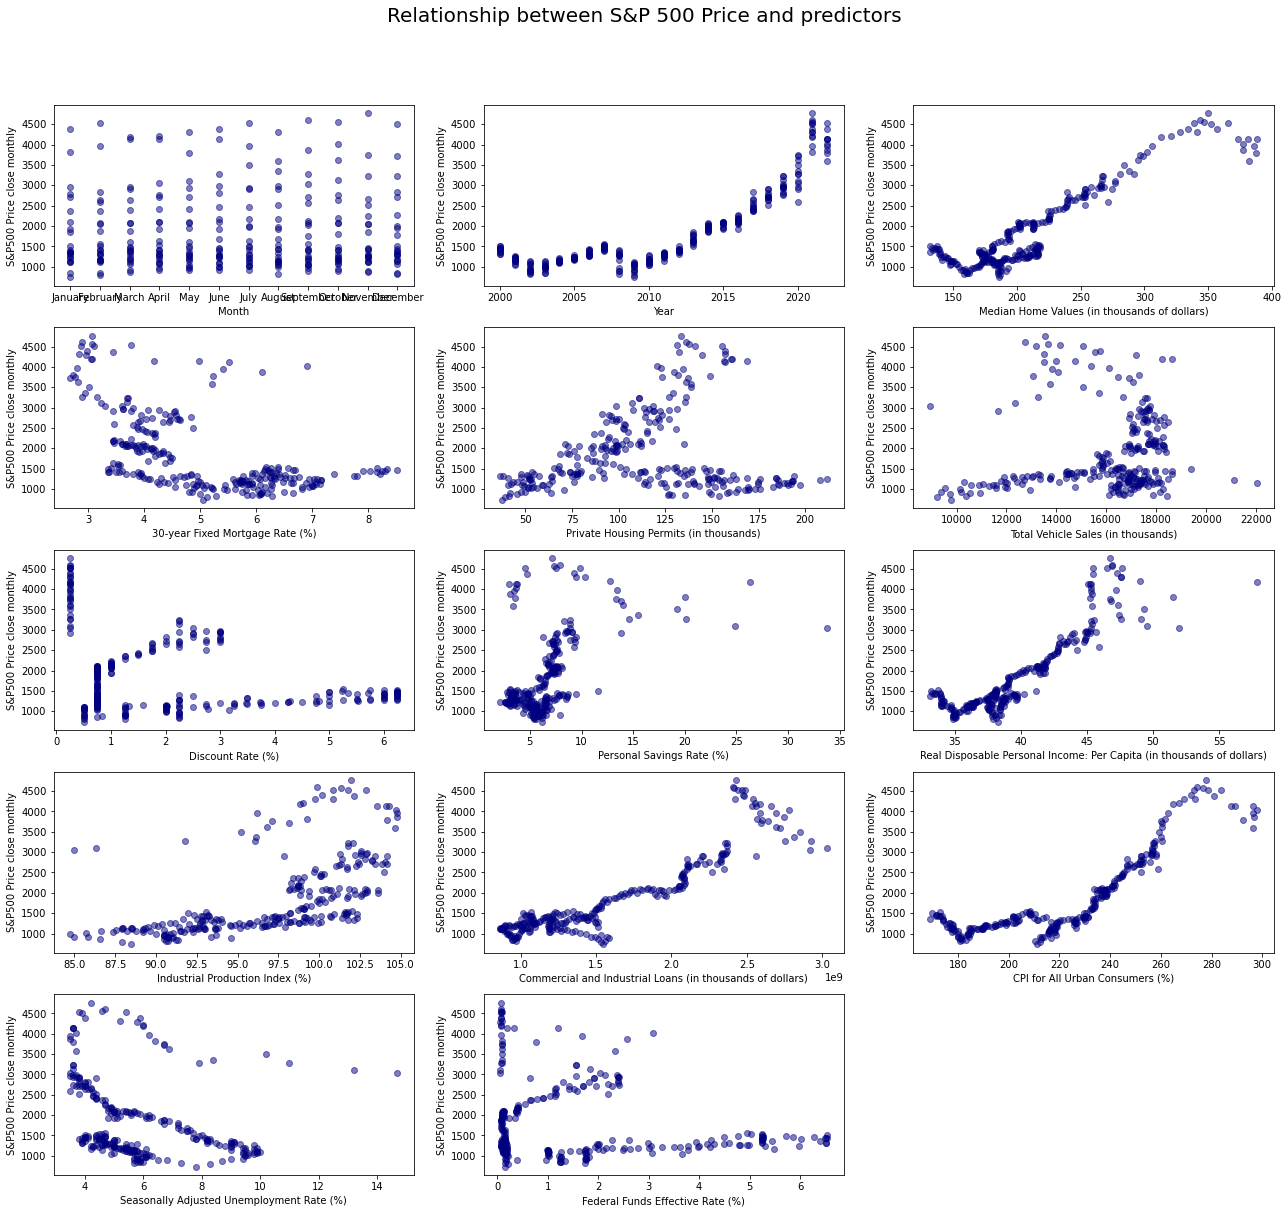

In [7]:
X = df.drop(["S&P500 price close at end of the month (^GSPC) (dollars)"], axis=1)
y = df['S&P500 price close at end of the month (^GSPC) (dollars)'] 

predictors = X.columns
fig, axes = plt.subplots(5, 3, figsize=(18, 16))
axes = axes.ravel()
i = 0 
for predictor in predictors: 
  axes[i].scatter(X[predictor], y, alpha=0.5, marker='o', c='navy')
  axes[i].set_ylabel("S&P500 Price close monthly",)
  axes[i].set_xlabel(f"{predictor}")
  i += 1
axes[14].set_axis_off()
plt.suptitle("Relationship between S&P 500 Price and predictors", fontsize=20, y = 1.05)
plt.tight_layout()
plt.savefig("output.jpg")
plt.show()

We can now represent our predictors against our response variable in order to take note of any observable patterns and trends. 

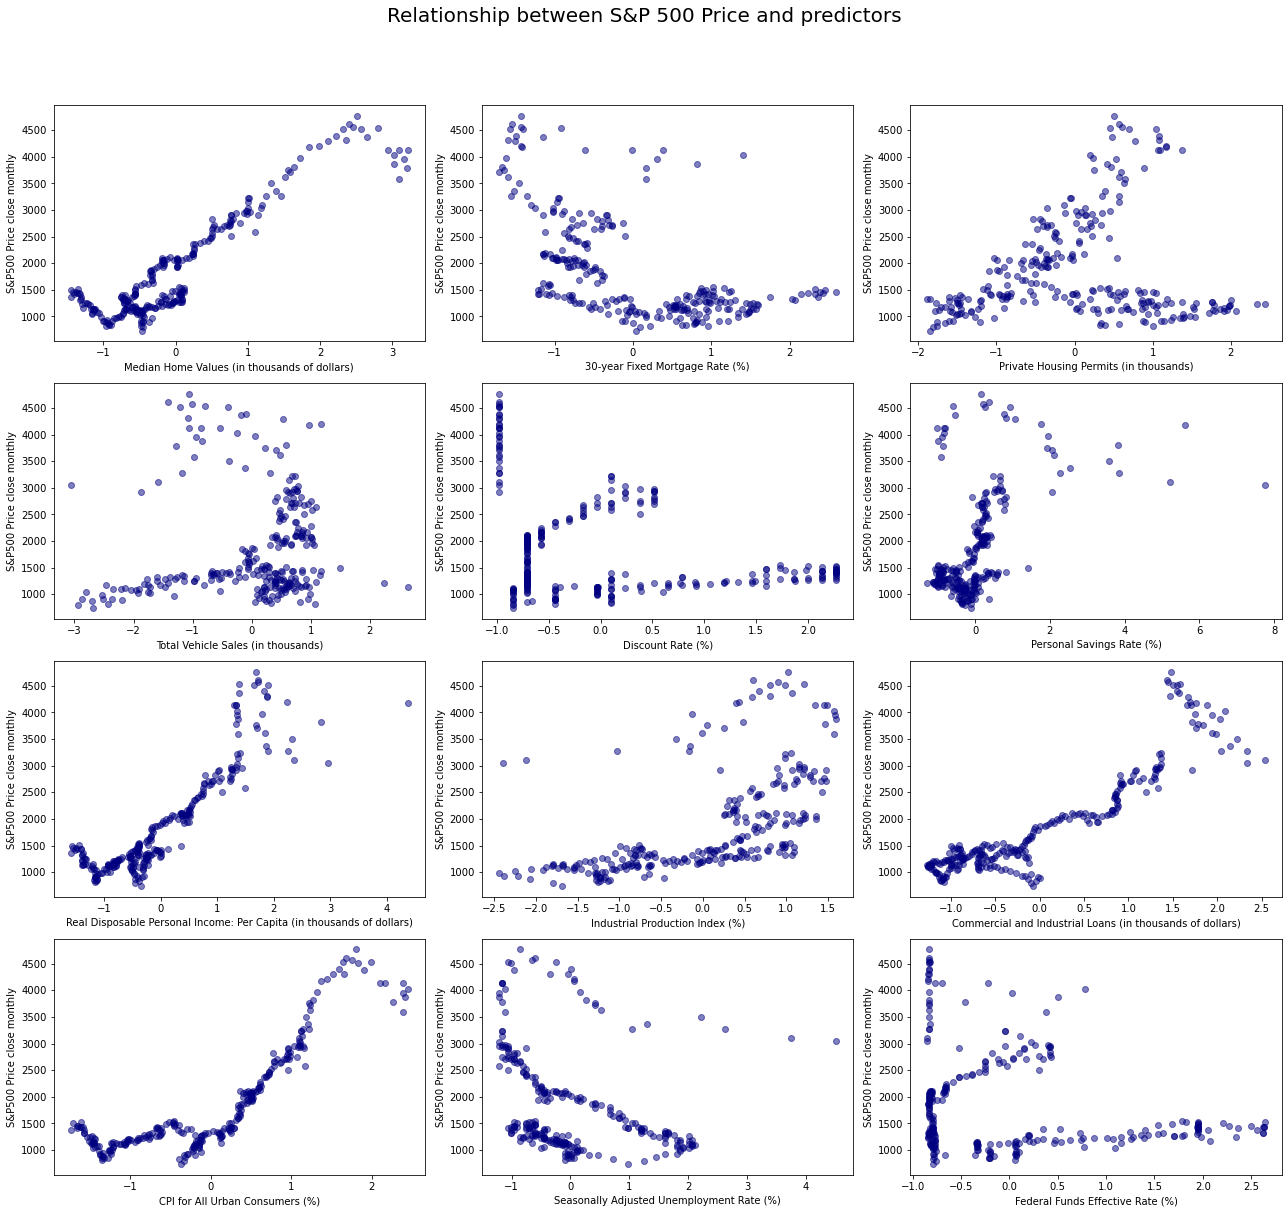

In [8]:
# Scale the Data, removing Month and Year columns
X_df2 = X.drop(['Month', 'Year'], axis=1)
scaler = StandardScaler().fit(X_df2) 
X_scaled = scaler.transform(X_df2) 
# Convert to Dataframe for plotting 
X_scaleddf = pd.DataFrame(X_scaled, columns=predictors[2:])

# Same plots as before but predictors are scaled
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.ravel()
i = 0 
for predictor in predictors[2:]: 
  axes[i].scatter(X_scaleddf[predictor], y, alpha=0.5, marker='o', c='navy')
  axes[i].set_ylabel("S&P500 Price close monthly",)
  axes[i].set_xlabel(f"{predictor}")
  i += 1
plt.suptitle("Relationship between S&P 500 Price and predictors", fontsize=20, y = 1.05)
plt.tight_layout()
plt.savefig("output2.jpg")
plt.show()

Our graphs show that most of our predictors are correlated with stock performance, thus their inclusion in our models will add value to predicting stock performance.

In [9]:
# Creating a Date column from Year and Month columns in order to observe data easier
df = df.astype({'Year':'string'})
df["Date"] = df["Month"].astype(str) +"-"+ df["Year"]
df["Date"] = pd.to_datetime(df['Date'], format='%B-%Y')
df["Date"] = df["Date"].dt.strftime('%Y-%m')

In [10]:
# Drop our old Year and Month date columns 
df = df.drop(["Year", "Month"], axis=1)

In [11]:
# Set x_train and y_train as described above
x_train = df.drop(["Date","S&P500 price close at end of the month (^GSPC) (dollars)"], axis=1)
y_train = df["S&P500 price close at end of the month (^GSPC) (dollars)"]
date = df["Date"]

In [12]:
# Scaled x_train data
scaled_x_train = StandardScaler().fit_transform(x_train, y_train)

In [13]:
# Set xticks
x_ticks = ["2000-01", "2001-01", "2002-01", "2003-01", "2004-01", 
            "2005-01", "2006-01", "2007-01", "2008-01", "2009-01",
            "2010-01", "2011-01", "2012-01", "2013-01", "2014-01",
            "2015-01", "2016-01", "2017-01", "2018-01", "2019-01",
            "2020-01", "2021-01", "2022-01", "2023-01"]

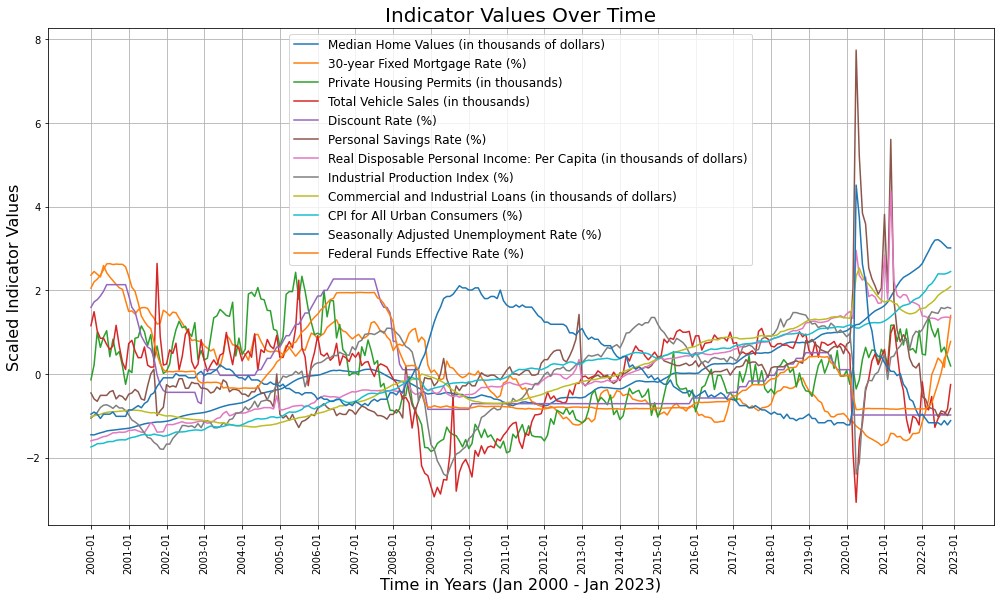

In [14]:
# Plot indicators over time
f = plt.figure(figsize=(14,8))
plt.plot(date, scaled_x_train)
plt.title("Indicator Values Over Time", fontsize=20)
plt.xlabel("Time in Years (Jan 2000 - Jan 2023)", fontsize=16)
plt.ylabel("Scaled Indicator Values", fontsize=16)
plt.legend(x_train.columns, loc="best", fontsize=12)
plt.tight_layout()
plt.xticks(x_ticks, rotation=90)
plt.grid();

We can split our indicators into various groups and plot smaller graphs in order to interpret the graps more easily. We will split up our indicators into groups determined by their units. We will end up with the following groups:
1. Currency Indicators: Median Home Values, Real Disposable Personal Income: Per Capita, Commercial and Industrial Loans
2. Integer Value Indicators: Private Housing Permits, Total Vehicle Sales
3. Percentage Rates: 30-year Fixed Mortgage Rate, Discount Rate, Personal Savings Rate, Seasonally Adjusted Unemployment Rate, Federal Funds Effective Rate
4. Percentage Indexes : Industrial Production Index, CPI for All Urban Consumers

In [15]:
# Set our various new train dfs as defined above
x_train_1 = df[["Median Home Values (in thousands of dollars)", 
                     "Real Disposable Personal Income: Per Capita (in thousands of dollars)", 
                     "Commercial and Industrial Loans (in thousands of dollars)"]]
x_train_2 = df[["Private Housing Permits (in thousands)", 
                     "Total Vehicle Sales (in thousands)"]]
x_train_3 = df[["30-year Fixed Mortgage Rate (%)", 
                     "Discount Rate (%)", 
                     "Personal Savings Rate (%)", 
                     "Seasonally Adjusted Unemployment Rate (%)", 
                     "Federal Funds Effective Rate (%)"]]
x_train_4 = df[["Industrial Production Index (%)", 
                     "CPI for All Urban Consumers (%)"]]

In [16]:
# Scale our new train data
scaled_data_1 = StandardScaler().fit_transform(x_train_1, y_train)
scaled_data_2 = StandardScaler().fit_transform(x_train_2, y_train)
scaled_data_3 = StandardScaler().fit_transform(x_train_3, y_train)
scaled_data_4 = StandardScaler().fit_transform(x_train_4, y_train)

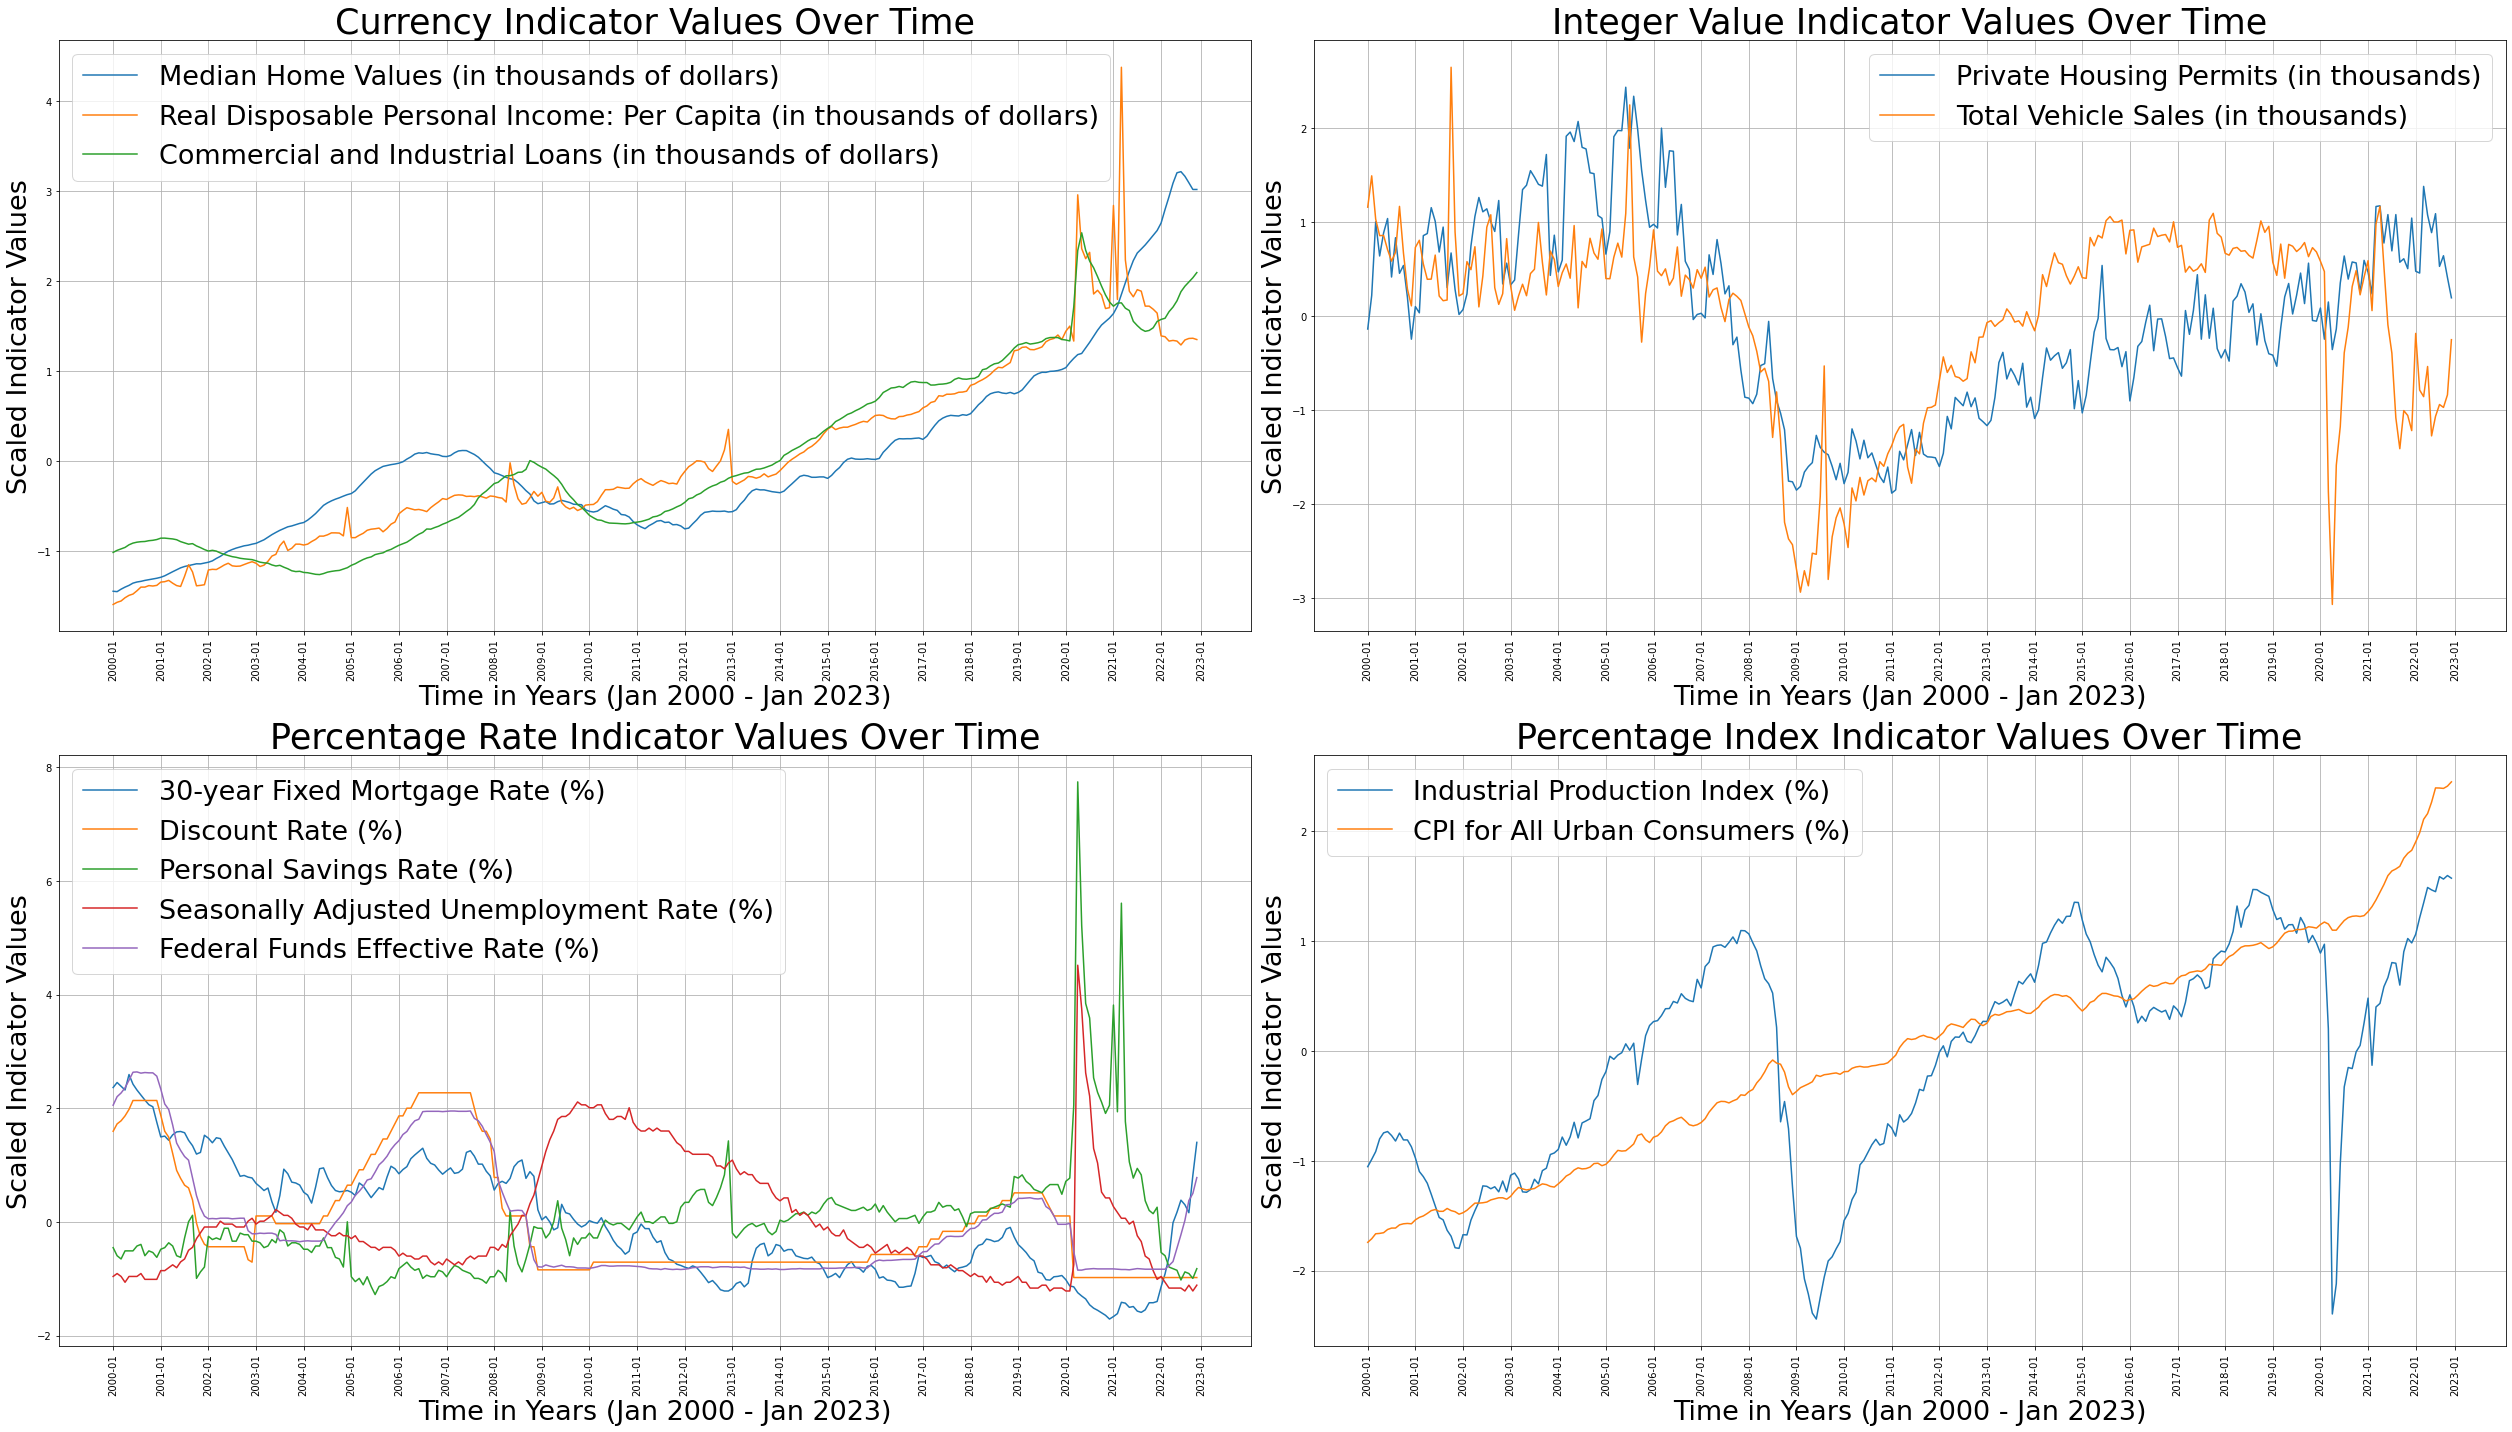

In [17]:
# Initialize lists to make plotting easier
scaled_data = [scaled_data_1, scaled_data_2, scaled_data_3, scaled_data_4]
categories = ["Currency", "Integer Value", "Percentage Rate", "Percentage Index"]
x_trains = [x_train_1, x_train_2, x_train_3, x_train_4]

# Plot data in 4 subplots 
f = plt.figure(figsize=(35,20))
i = 1
for category in scaled_data:
    plt.subplot(2,2,i)
    plt.plot(date, scaled_data[i-1])
    plt.title("{} Indicator Values Over Time".format(categories[i-1]), fontsize=35)
    plt.xlabel("Time in Years (Jan 2000 - Jan 2023)", fontsize=27)
    plt.ylabel("Scaled Indicator Values", fontsize=27)
    plt.legend(x_trains[i-1].columns, loc="best", fontsize=27)
    plt.tight_layout()
    plt.xticks(x_ticks, rotation=90)
    plt.grid();
    i=i+1

From the above graphs we can observe all of our 12 predictors much more clearly over time.

Now let us see how our response variable, the S&P 500 price, has changed over time.

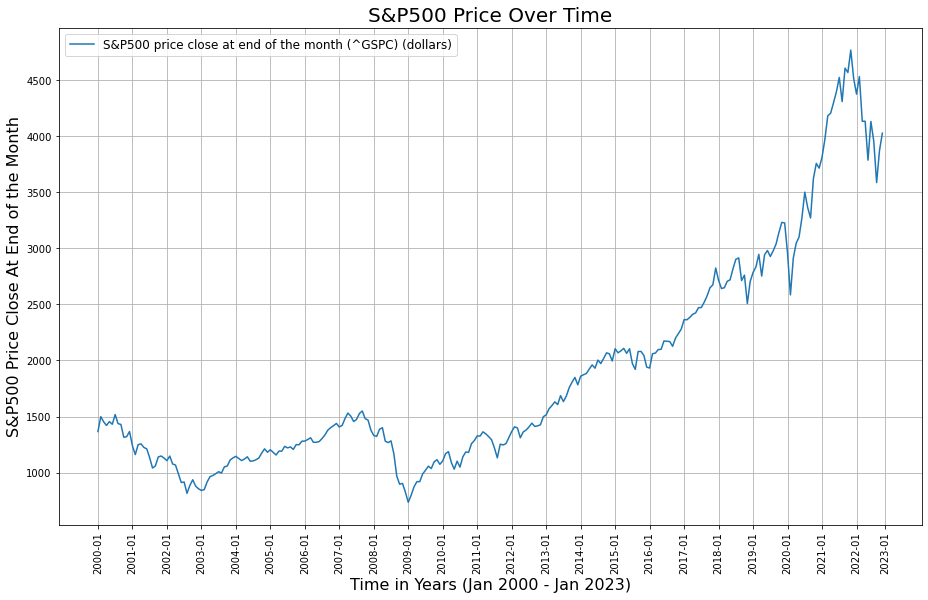

In [18]:
# Plot response variable over time
f = plt.figure(figsize=(13,8))
plt.plot(date, y_train)
plt.title("S&P500 Price Over Time", fontsize=20)
plt.xlabel("Time in Years (Jan 2000 - Jan 2023)", fontsize=16)
plt.ylabel("S&P500 Price Close At End of the Month", fontsize=16)
plt.legend(y_train.to_frame().columns, loc="best", fontsize=12)
plt.tight_layout()
plt.xticks(x_ticks, rotation=90)
plt.grid();

The possible effects of the recessions can be observed in this plot as well as we can see a dip in the S&P Price from 2008 to 2009 and we can also see a dip from late 2021 to present day. These are important observations because they help us understand the various factors that come into play that may affect the S&P Price which is what we are trying to predict.

## Modeling Stock Price Action With Time Series Models

The following is the time series plot for the S&P500 Closing Price shown again but without the dates for the purposes of this section.

In [19]:
xt = df["S&P500 price close at end of the month (^GSPC) (dollars)"].to_numpy()

p-value of the Augmented Dickey-Fuller test: 0.998160


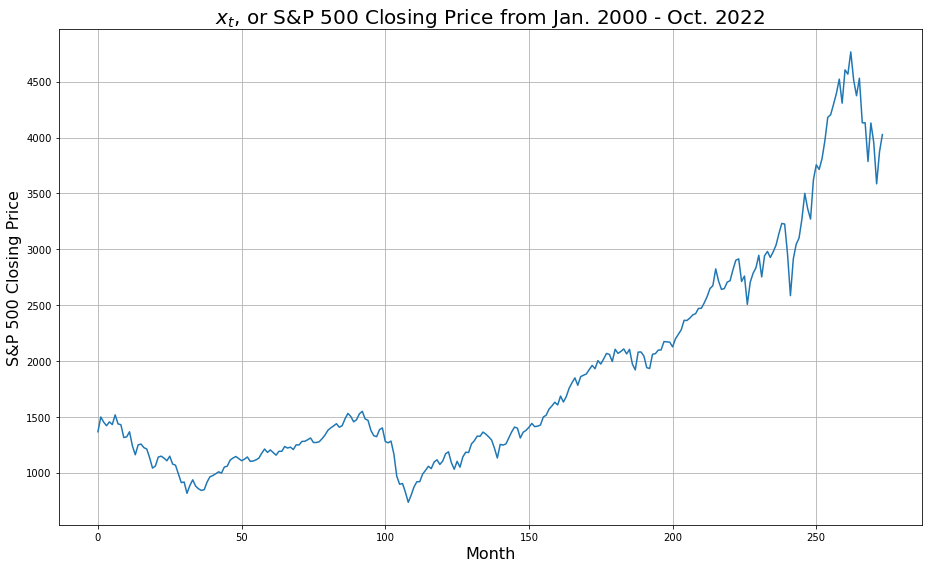

In [20]:
f = plt.figure(figsize=(13,8))
plt.plot(xt)
plt.title("$x_t$, or S&P 500 Closing Price from Jan. 2000 - Oct. 2022", fontsize=20)
plt.xlabel("Month", fontsize=16)
plt.ylabel("S&P 500 Closing Price", fontsize=16)
plt.tight_layout()
plt.grid();
print('p-value of the Augmented Dickey-Fuller test: %f' % adfuller(xt)[1])

Before any plot analysis, we define stationarity for a time series to be the case where the time series seems to bounce around a constant mean, and there is a constant variance as time increases. What we mean by constant variance is that each point should be generated from independently identical distributions with 0 mean and constant variance.

From this plot, we can see that this is not a stationary time series, due to the upward trending nature of the plot. We can also statistically verify that this is the case by using the Augmented Dickey-Fuller (ADF) test, which gives us a p-value of almost 1, meaning this time series is in fact not stationary.

The plot below is the first difference of the original time series. We take each point in the original time series and subtract it from the point before, giving us a new construction of the original time series (known as the first difference).

p-value of the Augmented Dickey-Fuller test: 0.000047


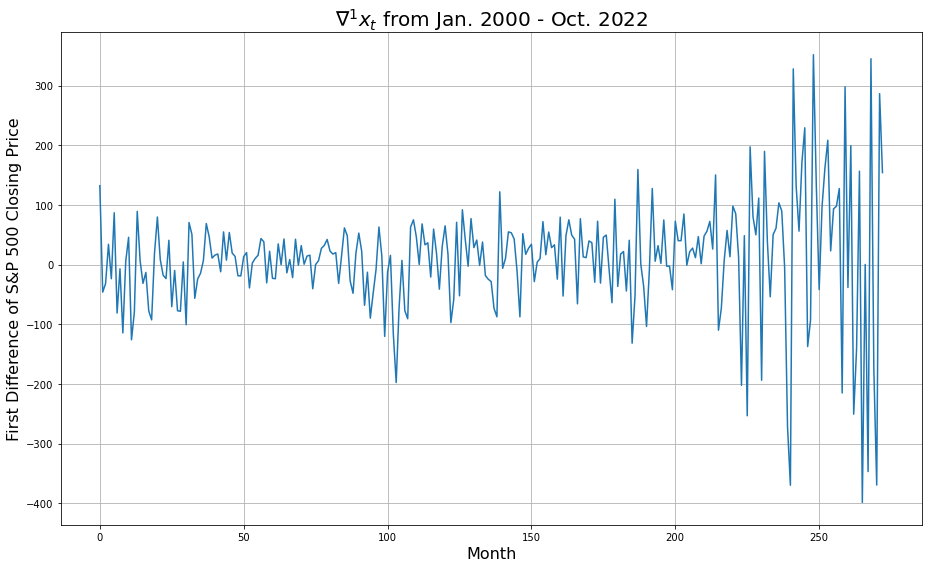

In [21]:
xt_diff = np.diff(xt)

f = plt.figure(figsize=(13,8))
plt.plot(xt_diff)
plt.title(r"$\nabla^1 x_t$ from Jan. 2000 - Oct. 2022", fontsize=20)
plt.xlabel("Month", fontsize=16)
plt.ylabel("First Difference of S&P 500 Closing Price", fontsize=16)
plt.tight_layout()
plt.grid();
print('p-value of the Augmented Dickey-Fuller test: %f' % adfuller(xt_diff)[1])

Here we can see that the plot seems to be close to our definition of stationary, however there is a changing variance as time increases (hence the volatility of the time series). Therefore, we cannot fully categorize this time series to be stationary. Also, even though the p-value from the ADF test seems to indicate stationarity, the ADF test fails to take into account the changing variance - we cannot look towards the ADF test anymore when dealing with stationarity.

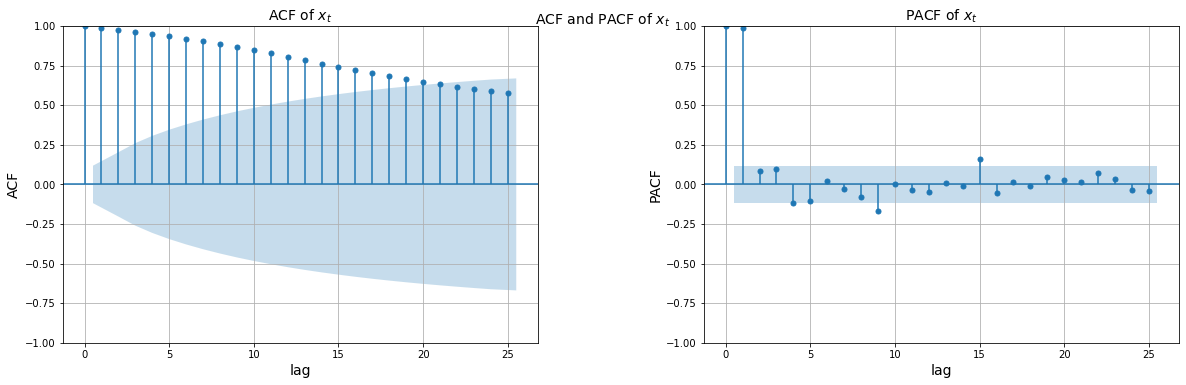

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(20,5), squeeze = False)
plt.suptitle("ACF and PACF of $x_t$",y=0.92,size=14)
plt.subplots_adjust(wspace = 0.35,hspace = 0.5,bottom = 0)

plot_acf(xt, ax=ax[0][0])
ax[0][0].set_xlabel("lag",fontsize=14)
ax[0][0].set_ylabel("ACF",fontsize=14)
ax[0][0].set_title("ACF of $x_t$",fontsize=14)
ax[0][0].grid(True)

plot_pacf(xt, ax=ax[0][1], method = "ywm")
ax[0][1].set_xlabel("lag",fontsize=14)
ax[0][1].set_ylabel("PACF",fontsize=14)
ax[0][1].set_title("PACF of $x_t$",fontsize=14)
ax[0][1].grid(True)

Above are the ACF and PACF plots of the original time series. We do this to construct a base model for the purposes of comparison with future models. Initial analysis shows a geometrically decaying ACF, with a PACF with a hard cutoff at lag = 1. Therefore, we can make our baseline model to be AR(1) as long as we assume the time series to be stationary (even though it isn't).

For the purposes of this section, we will be developing time series models using data points from the time series up until the last 10 months for training the models, and the last 10 months for testing the models.

In [23]:
# use last 10 points as test
xt_train = xt[:-10]
xt_test = xt[-10:]
xt_test.shape

(10,)

In [24]:
# try to make a model from this - AR(1)
ar_model = ARIMA(xt_train, order=(1,0,0))
model_fit = ar_model.fit(method='innovations_mle')
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  264
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1549.712
Date:                Sun, 11 Dec 2022   AIC                           3105.424
Time:                        22:30:56   BIC                           3116.152
Sample:                             0   HQIC                          3109.735
                                - 264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2741.0993   1513.281      1.811      0.070    -224.878    5707.076
ar.L1          0.9984      0.005    207.110      0.000       0.989       1.008
sigma2      7190.8514    371.713     19.345      0.0

In [25]:
# predict last 10 points of xt
n = xt_train.shape[0]
m = xt_test.shape[0]
xt_fitted = model_fit.predict()
xt_forecasted = model_fit.predict(start=n+1, end=n+m)

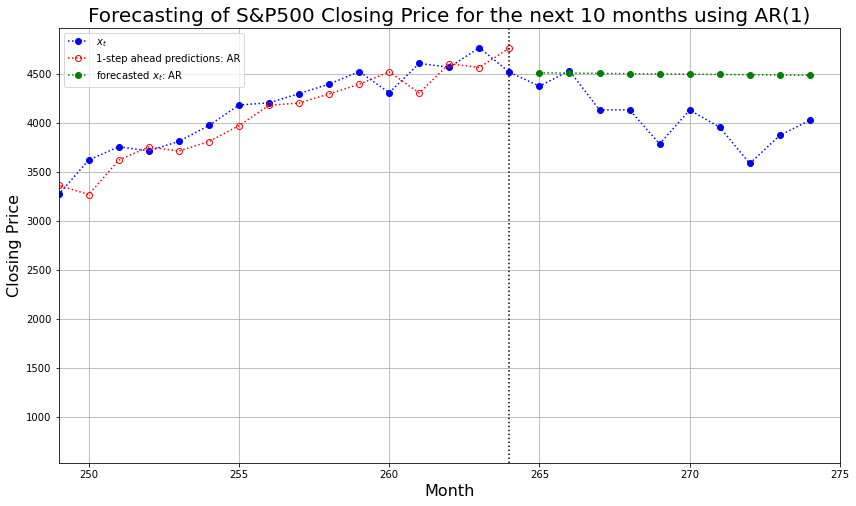

In [26]:
plt.figure(figsize=(14,8))
plt.plot(range(1,xt.shape[0] + 1),xt,linestyle=':', marker='o',color='blue',label = "$x_t$")
plt.plot(range(1,n+1),xt_fitted,linestyle=':', marker='o', mfc='none', color='red',label = "1-step ahead predictions: AR")
plt.plot(range(n+1,n+m+1), xt_forecasted, linestyle=':', marker='o',color='green',label = "forecasted $x_t$: AR")
plt.axvline(x=n,linestyle=':',color='k')
plt.title("Forecasting of S&P500 Closing Price for the next 10 months using AR(1)", fontsize=20)
plt.xlabel("Month", fontsize=16)
plt.ylabel("Closing Price", fontsize=16)
plt.legend(loc='upper left')
plt.xlim(n-15,n+m+1)
plt.grid();

From the plot above, we are able to make (terrible) predictions for the test points. We see that the model does fairly well when making predictions for points it has already seen, but when predicting for points it hasn't seen it gives a straight line. This is an indication that the model has overfit on the train data points. In fact, this is the case due to the time series not bouncing around a specific mean and not having constant variance (aka not being stationary). 

For the baseline model, we obtain an MSE value of 263451.37 - therefore, when developing newer models we should aim to have models that generate MSE values lower than this.

In [27]:
# calculate mse
mse = mean_squared_error(xt_test, xt_forecasted)
mse

263451.37435790646

To determine the order of the time series, we can either play around with the time series and find a newly constructed version and look at its ACF and PACF, or we can use the Python module pmdarima, which can calculate the order for us. 

For this time series, we found the model to be ARIMA(2, 1, 2) - the first 2 gives us the order AR(2), the last 2 gives us the order MA(2), and 1 indicates that the model uses the first difference of the original time series. We can claim this model to be ARMA(2, 2) for the time series constructed from the first differences of the original time series.

In [28]:
# get order of time series for ARIMA
arima_model_fitted = auto_arima(xt)
p, d, q = arima_model_fitted.order
print("ARIMA(%s, %s, %s)" % (p, d, q))

ARIMA(2, 1, 2)


In [29]:
def plot_acf_pacf_helper(res):
    h_max = 50

    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(15,4))
    #fig.suptitle("AR(" + str(p_ar) + ")-GARCH(" + str(p_garch) + "," + str(q_garch) + ") process",y=1.08,size=16)
    plt.subplots_adjust(wspace = 0.15)
    plot_acf(res, ax=ax[0], lags=h_max)
    plot_pacf(res, ax=ax[1], lags=h_max, method='ywm')

    for k in range(2):
        ax[k].tick_params(axis='both', labelsize=12)
        [ax[k].spines[line].set_alpha(.3) for line in ["top","bottom","right","left"]]

    ax[0].set_title("Sample ACF")
    ax[1].set_title("Sample PACF")

    plt.show()

The following function is used to generate MSEs and plots of the time series. It accepts a time series, a p, i, and q value for the ARIMA component, and a p and q value for the GARCH component of the time series. This function can be used for any time series, but it is up to the user to figure out the orders for the model.

The function prints ACF and PACF plots for the residuals and squared residuals of the fit models. The purpose of this is to determine the order for the AR component of the GARCH component of the time series - however, for our time series, it does not seem to generate any meaningful plots. Nonetheless, it is still included for future reference.

The function predicts the forecasted ARIMA values and GARCH values for 10 step ahead predictions as well as rolling predictions. In addition, it plots the time series as well as these three predictions for comparison purposes.

Finally, the function also returns the three MSE values for these three predictions.

In [30]:
def model_stats(xt, arima_p = 1, arima_i = 0, arima_q = 0, garch_p = 1, garch_q = 0, print_plots = True):
    xt_train = xt[:-10]
    xt_test = xt[-10:]
    xt_test.shape
    
    arima_model = ARIMA(xt_train, order=(arima_p,arima_i,arima_q))
    arima_model_fit = arima_model.fit(method='innovations_mle')
    #print(model_fit.summary())
    n = xt_train.shape[0]
    m = xt_test.shape[0]
    xt_fitted = arima_model_fit.predict()
    xt_forecasted = arima_model_fit.predict(start=n+1, end=n+m)
    res = arima_model_fit.resid
    
    #arima_model_fitted = pmdarima.auto_arima(xt)
    #p, d, q = arima_model_fitted.order
    #print("ARIMA(%s, %s, %s)" % (p, d, q))
    #arima_residuals = arima_model_fitted.arima_res_.resid
    
    if print_plots:
        plot_acf_pacf_helper(res)
        plot_acf_pacf_helper(res**2)
    
    garch = arch_model(xt_train, p = garch_p, q = garch_q)
    garch_fitted = garch.fit(disp = "off")
    #print(garch_fitted.summary())
    
    # predicting volatility
    predictions = garch_fitted.forecast(horizon = 10)
    #print(predictions.mean.values[-1])
    
    rolling_preds = []
    
    for i in range(10):
        train = xt[:-(10 - i)]
        model = arch_model(train, p = garch_p, q = garch_q)
        model_fit = model.fit(disp = "off")
        pred = model_fit.forecast(horizon = 1)
        #print(pred.mean.values[-1, :][0])
        #print(pred.variance.values[-1, :][0])
        rolling_preds.append(pred.mean.values[-1, :][0] + np.sqrt(pred.variance.values[-1, :][0]))
    #print(rolling_preds)
    
    ten_step_preds = predictions.mean.values[-1, :] + np.sqrt(predictions.variance.values[-1, :])
    
    if print_plots:
        plt.figure(figsize=(14,8))
        plt.plot(xt, linestyle=':', marker='o',color='blue',label = "$x_t$")
        plt.plot(range(n+1, n+m+1), xt_forecasted, marker='o',color='red', label = "ARIMA(%s, %s, %s) predictions (no GARCH)" % (arima_p, arima_i, arima_q))
        plt.plot(range(n+1, n+m+1), ten_step_preds, marker='o',color='green', label = "ten step ahead predictions")
        plt.plot(range(n+1, n+m+1), rolling_preds, marker='o',color='purple', label = "rolling predictions one step ahead")
        #plt.plot(xt_test, label = "actual values")
        plt.legend(loc = 'lower right')
        plt.xlabel("Month")
        plt.ylabel("Closing Price")
        plt.title("Forecasts of S&P500 Closing Price for the next 10 months")
        plt.xlim(n-10,n+m+1)
        plt.axvline(x=n,linestyle=':',color='k')

        plt.show()
    
    mses = []
    mse = mean_squared_error(xt_test, xt_forecasted)
    mses.append(mse)
    if print_plots:
        print("MSE of ARIMA(%s, %s, %s) predictions (no GARCH)" % (arima_p, arima_i, arima_q), mse, ".")
    mse = mean_squared_error(xt_test, ten_step_preds)
    mses.append(mse)
    if print_plots:
        print("MSE of ten_step_preds:", mse, ".")
    mse = mean_squared_error(xt_test, rolling_preds)
    mses.append(mse)
    if print_plots:
        print("MSE of rolling_preds:", mse, ".")
    #print(ten_step_preds)
    #print(rolling_preds)
    #print(xt_test)
    return mses # used for testing multiple garch models

Here we test a range of GARCH components - the p range is from 1-3, and the q range is from 0-3. We obtain the MSEs for each of the models constructed, used later for comparison purposes.

In [31]:
mses = []
for p in range(1, 4):
    for q in range(0, 4):
        #print("Testing ARIMA(2, 1, 2)-GARCH(%s, %s)" % (p, q))
        mse = model_stats(xt, arima_p = 2, arima_i = 1, arima_q = 2, garch_p = p, garch_q = q, print_plots = False)
        mses.append([p, q, mse])

In [32]:
mses # best models are GARCH(1, 2) -> low ten_step_pred mse; GARCH(1, 3)-> low rolling_pred mse 
#but ten_step_pred for these models is not showing much change than GARCH(1, 0) -> probs best model overall for seeing trend in ten_step_pred

[[1, 0, [559454.8448142122, 1268200.836361391, 167262.43479899172]],
 [1, 1, [559454.8448142122, 291704.059469466, 70252.34501745486]],
 [1, 2, [559454.8448142122, 291700.432295513, 70246.58820376327]],
 [1, 3, [559454.8448142122, 302056.5518047155, 69998.42452558305]],
 [2, 0, [559454.8448142122, 1268207.5308574464, 167288.71576909994]],
 [2, 1, [559454.8448142122, 291748.27552255295, 70249.85295421066]],
 [2, 2, [559454.8448142122, 291714.6404227234, 70255.14920091988]],
 [2, 3, [559454.8448142122, 302088.1546371992, 69996.78699923352]],
 [3, 0, [559454.8448142122, 1268215.3598229527, 167278.85670591757]],
 [3, 1, [559454.8448142122, 291715.44742346456, 70249.11589704994]],
 [3, 2, [559454.8448142122, 291716.3245875469, 70244.3347764522]],
 [3, 3, [559454.8448142122, 302024.86550956295, 70007.89524116578]]]

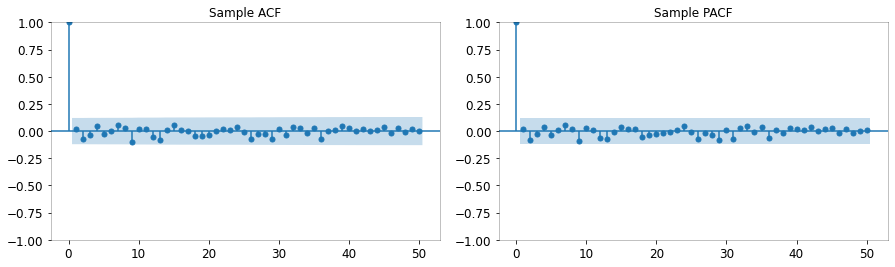

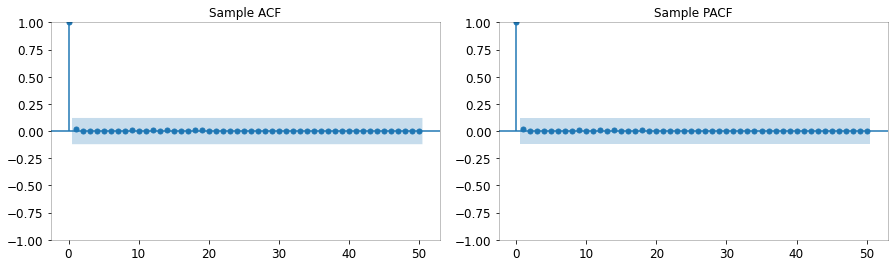

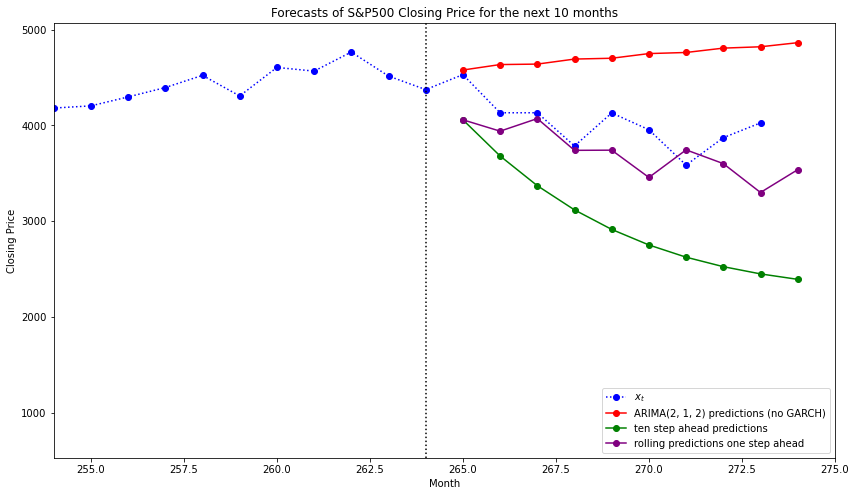

MSE of ARIMA(2, 1, 2) predictions (no GARCH) 559454.8448142122 .
MSE of ten_step_preds: 1268207.5308574464 .
MSE of rolling_preds: 167288.71576909994 .


[559454.8448142122, 1268207.5308574464, 167288.71576909994]

In [33]:
mses = model_stats(xt, arima_p = 2, arima_i = 1, arima_q = 2, garch_p = 2, garch_q = 0)
mses

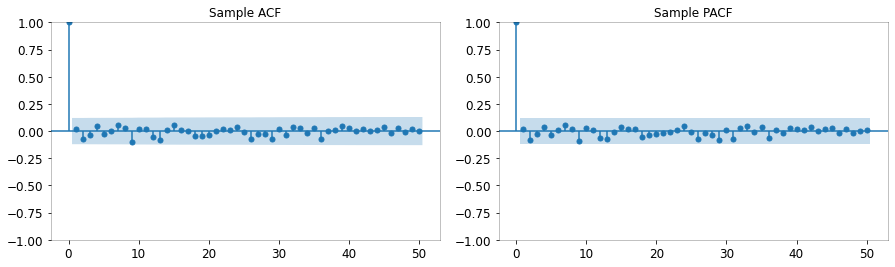

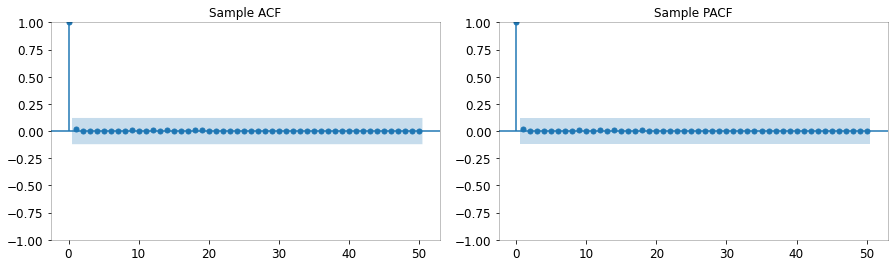

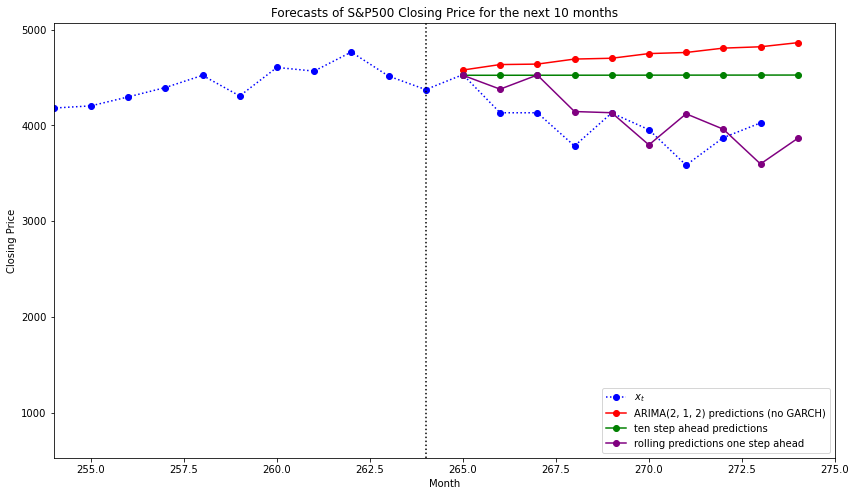

MSE of ARIMA(2, 1, 2) predictions (no GARCH) 559454.8448142122 .
MSE of ten_step_preds: 291714.6404227234 .
MSE of rolling_preds: 70255.14920091988 .


[559454.8448142122, 291714.6404227234, 70255.14920091988]

In [34]:
mses = model_stats(xt, arima_p = 2, arima_i = 1, arima_q = 2, garch_p = 2, garch_q = 2)
mses

Overall, the best models seem to be ARIMA(2,1,2)-GARCH(2,0), ARIMA(2,1,2)-GARCH(2,2). We believe these to be the best models because of their low MSE values (the GARCH(2,0) model has a lower ten_step_pred MSE, and the GARCH(2,2) has a lower rolling_pred MSE). While we obtain lower MSE values than the original MSE value from the AR(1) model, more work will need to be done to obtain even lower values (e.g. different time series models, scaling of data, etc.).

## Modeling Stock Price Action With Random Forest

### Random Forest Method

The random forest regression model is used for prediction and the model is aimed at predicting the future S&P500 prices for the next 12 months. Random forests provide a high accuracy when precicting so it is a good choice for a model in this case. The random forest technique can also handle big data with numerous variables running into thousands like ours.

#### Preprocessing Data

In [35]:
# Perform train test split
X_train80, X_test, y_train80, y_test = train_test_split(x_train.values,
                                                    y_train.values,
                                                    train_size=.8,
                                                    random_state=0)

In [36]:
# Preprocess: Standardize data
scale = StandardScaler()
X_train80 = scale.fit_transform(X_train80)
X_test = scale.transform(X_test)

In [76]:
# Hyperparamter Tuning
grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),
'random_state': [1, 2, 30, 42]
}
model=RandomForestRegressor()
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(X_train80, y_train80)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 2, 'n_estimators': 100, 'max_depth': 8}


#### Apply Model and Predict

In [38]:
# Evaluate results
rforest = RandomForestRegressor(n_estimators=100, random_state=2, max_depth=8)

random_forest_train_score = rforest.fit(X_train80, y_train80).score(X_train80, y_train80)
random_forest_test_score = rforest.fit(X_train80, y_train80).score(X_test, y_test)

In [39]:
# Print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        10,
        1000,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-10 and 1000 trees achieves the following accuracy scores:

	train	0.9986
	TEST	0.9894


In [40]:
# Predict future prices
predict = rforest.predict(X_test)
print(predict)
print(predict.shape)

[2674.67       4633.774      2274.8125      860.87305    2032.879
 1664.267      1475.26599286 2867.0425     1126.31632143 2180.3665
 2653.992      3280.4205     2567.2495     1135.56225    1372.36884167
 1173.16883333 1375.81849118 1359.17320159 1184.15462329 2035.401
 1117.3217375  1062.71754464 2522.255      1654.879      1205.24157321
 1411.62990784 1449.35021548 3139.689      1937.7745     1392.60918164
 1332.00443631 1081.61585714 1291.34933967 2905.2545     1280.25732083
 1200.69739118 2921.9285     1407.75568164 1228.50113817 4565.2925
 1344.76677717 2753.9035     1977.91708333 1010.9395      949.77598214
 2848.6705     2009.84233333 2040.1965     2702.678       905.542
 4060.066      1235.89936618 1105.43410417 1294.03130833 1997.8565    ]
(55,)


#### Statistical Metrics and Performance Evaluation

In [41]:
# Print results summary
print("Mean Absolute Error:", round(mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(r2_score(y_test, predict), 4))
print(f'Train Score : {rforest.score(X_train80, y_train80) * 100:.2f}% and Test Score : {rforest.score(X_test, y_test) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 62.4663
Mean Squared Error: 8066.1259
Root Mean Squared Error: 89.8116
(R^2) Score: 0.9894
Train Score : 99.86% and Test Score : 98.94% using Random Tree Regressor.
Accuracy: 96.33 %.


## Modeling Stock Price Action using LASSO Regression

### Linear Regression

In [42]:
# Specify X and y 
X = df.drop(['S&P500 price close at end of the month (^GSPC) (dollars)'], axis=1)
y = df['S&P500 price close at end of the month (^GSPC) (dollars)'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [43]:
# Drop Date from Model Learning since it is Datetime data type
# Keep it in X so we can plot time against predictions 
X_train_yr = X_train.drop(['Date'], axis=1) 
X_test_yr = X_test.drop(['Date'], axis=1)

In [44]:
# Function that returns metrics for models given model and data
def get_metrics(model, X_train, X_test) -> dict: 
    metrics = {} 
    y_hat_train = model.predict(X_train) 
    y_hat_test = model.predict(X_test) 
    metrics['train_mse'] = mean_squared_error(y_train, y_hat_train) 
    metrics['test_mse'] = mean_squared_error(y_test, y_hat_test) 
    metrics['train_r2'] = r2_score(y_train, y_hat_train) 
    metrics['test_r2'] = r2_score(y_test, y_hat_test) 
    test_errors = abs(y_hat_test - y_test)
    test_mape = 100 * (test_errors / y_test)
    metrics['test_accuracy'] = 100 - np.mean(test_mape)
    train_errors = abs(y_hat_train - y_train)
    train_mape = 100 * (train_errors / y_train)
    metrics['train_accuracy'] = 100 - np.mean(train_mape)
    return metrics 

In [64]:
# SLR fit on all predictors 
linreg = LinearRegression().fit(X_train_yr, y_train)
metrics = get_metrics(linreg, X_train_yr, X_test_yr) 
results = [] 
results.append({'model': "SLR", 
                'train_mse': metrics['train_mse'],
                'test_mse': metrics['test_mse'],
               'train_r2': metrics['train_r2'], 
                'test_r2': metrics['test_r2'],
                'train_accuracy': metrics['train_accuracy'], 
                'test_accuracy': metrics['test_accuracy']
               })

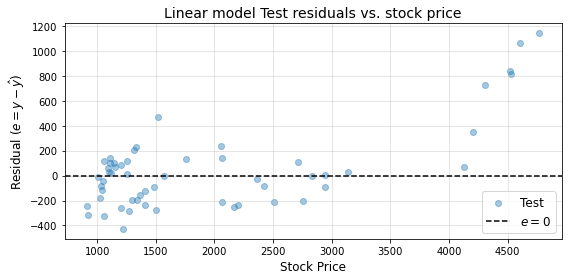

In [46]:
# Test set residuals
y_hat_test = linreg.predict(X_test_yr) 
y_hat_train = linreg.predict(X_train_yr)
test_residuals = y_test - y_hat_test

# Test Residual Plot
plt.figure(figsize=(8, 4))
plt.scatter(y_test, test_residuals, alpha=0.4, label="Test")
plt.axhline(color="black",linestyle="dashed", label="$e=0$")
plt.title(
    "Linear model Test residuals vs. stock price",
    fontsize=14,
)
plt.xlabel("Stock Price", fontsize=12)
plt.ylabel("Residual ($e = y - \hat{y}$)", fontsize=12)
plt.legend(fontsize=12, loc=4)
plt.grid(":", alpha=0.4)
plt.tight_layout()

Since we are predicting a quantitative response variable, our problem statement reduces down to a regression problem. Hence, we fit a simple linear regression (SLR) model to predict stock prices. The model is appropriate since all predictors had linear relationships with our response variable. Additionally, our residual plot confirmed the appropriateness of our model by showing that our residuals were randomly scattered. However, we feel that our model can be improved by introducing some complexity and running a polynomial regression.

### Polynomial Regression 

In [67]:
# Fit various polynomial degree models and store mses for each
include_bias = False
fit_intercept = True 
max_degree = 10
degrees = [i for i in range(1, max_degree+1)] 
train_mses, val_mses = [], [] 

for d in degrees:
    X_poly_train = PolynomialFeatures(d, include_bias=include_bias).fit_transform(X_train_yr)
    X_poly_val = PolynomialFeatures(d, include_bias=include_bias).fit_transform(X_test_yr)
    lin_reg = LinearRegression(fit_intercept=fit_intercept)
    lin_reg.fit(X_poly_train, y_train)
    y_train_pred = lin_reg.predict(X_poly_train)
    y_val_pred = lin_reg.predict(X_poly_val)

    train_mses.append(mean_squared_error(y_train,y_train_pred))
    val_mses.append(mean_squared_error(y_test,y_val_pred))

# Find Best Degree
best_idx = np.argmin(val_mses)
best_degree = degrees[best_idx]

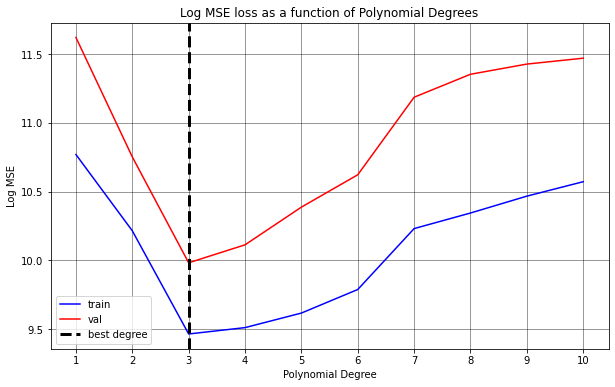

In [48]:
# MSE Loss as function of Polynomial degree
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(degrees, np.log(train_mses), label="train", linestyle = '-', color='blue'); 
ax.plot(degrees, np.log(val_mses), label="val", linestyle = '-', color='red'); 
ax.axvline(x = best_degree, linestyle='--', linewidth = 3, color='black', label='best degree') 
ax.grid(color='black', alpha=0.5);
ax.set_xticks(degrees);
ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('Log MSE') 
ax.set_title('Log MSE loss as a function of Polynomial Degrees') 
ax.legend(); 
plt.savefig("MSE Loss Polynomial")

In [66]:
# Fit the Best Degree Model and store results
X_poly_train = PolynomialFeatures(best_degree, include_bias=include_bias).fit_transform(X_train_yr)
X_poly_val = PolynomialFeatures(best_degree, include_bias=include_bias).fit_transform(X_test_yr)
lin_reg = LinearRegression(fit_intercept=fit_intercept).fit(X_poly_train, y_train) 
metrics = get_metrics(lin_reg, X_poly_train, X_poly_val)
results.append({'model': "Best Polynomial (Degree {})".format(best_degree), 
                'train_mse': metrics['train_mse'],
                'test_mse': metrics['test_mse'],
               'train_r2': metrics['train_r2'], 
                'test_r2': metrics['test_r2'],
                'train_accuracy': metrics['train_accuracy'], 
                'test_accuracy': metrics['test_accuracy']
               })

In [65]:
# Cross Validation, same results but runtime extremely slow 
k = 2 
train_mses_mean, val_mses_mean = [], []

for degree in degrees:
    poly4 = PolynomialFeatures(degree=degree, include_bias=include_bias)
    x_poly_train = poly4.fit_transform(X_train_yr)  
    cur_linreg = LinearRegression(fit_intercept = fit_intercept).fit(x_poly_train, y_train) 
    mse_score = cross_validate(cur_linreg, x_poly_train, y_train, 
                           cv=k, scoring="neg_mean_squared_error", return_train_score=True)
    train_mses_mean.append(-1*np.mean(mse_score['train_score'])) 
    val_mses_mean.append(-1*np.mean(mse_score['test_score'])) 

# Best Degree
best_idx = np.argmin(val_mses_mean) 
best_degree = degrees[best_idx]

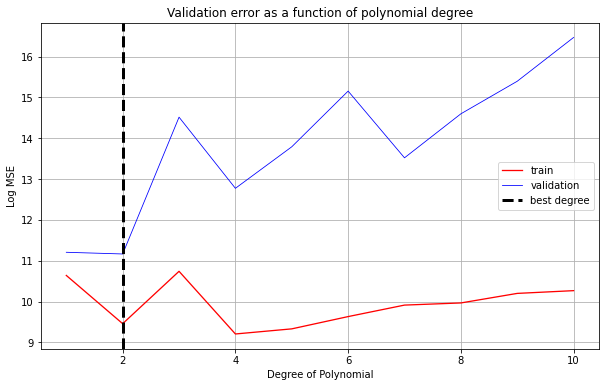

In [51]:
# Same figure as before 
fig, ax = plt.subplots(figsize=(10, 6)) 
ax.plot(degrees, np.log(train_mses_mean), lw=1.3, color='red', label='train');
ax.plot(degrees, np.log(val_mses_mean), lw=0.8, color='blue', label='validation');
ax.axvline(x = best_degree, linestyle='--', linewidth = 3, color='black', label='best degree') 
ax.set_xlabel('Degree of Polynomial');
ax.set_ylabel('Log MSE');
ax.legend();
ax.grid();
ax.set_title('Validation error as a function of polynomial degree');
plt.savefig("MSE Loss Polynomial CV")

In [68]:
# Fit Best Degree model and store results
X_poly_train = PolynomialFeatures(best_degree, include_bias=include_bias).fit_transform(X_train_yr)
X_poly_val = PolynomialFeatures(best_degree, include_bias=include_bias).fit_transform(X_test_yr)
lin_reg = LinearRegression(fit_intercept=fit_intercept).fit(X_poly_train, y_train) 
metrics = get_metrics(lin_reg, X_poly_train, X_poly_val)
results.append({'model': "Best Polynomial CV (Degree {})".format(best_degree), 
                'train_mse': metrics['train_mse'],
                'test_mse': metrics['test_mse'],
               'train_r2': metrics['train_r2'], 
                'test_r2': metrics['test_r2'], 
                'train_accuracy': metrics['train_accuracy'], 
                'test_accuracy': metrics['test_accuracy']
               })

The increased complexity paid off with better model performance using polynomial regression. Using a single validation set, we found the best degree was 5 but this varies by random state. However, using cross validation, we consistently found that degree 2 was the best model. Although in this case, degree 5 is the best performing model, we will proceed with degree 2 since cross validation is more accurate than single validation at delivering models that generalize well. 

### KNN Regression

In [53]:
# KNN Model 
train_mses = []
test_mses = [] 
neighbors = [i for i in range(1, 100)] 
for k in neighbors: 
    cur_knn = KNeighborsRegressor(n_neighbors=k).fit(X_train_yr, y_train) 
    cur_metrics = get_metrics(cur_knn, X_train_yr, X_test_yr) 
    train_mses.append(cur_metrics['train_mse']) 
    test_mses.append(cur_metrics['test_mse']) 

# Find Best K 
best_idx = np.argmin(test_mses) 
best_k = neighbors[best_idx] 

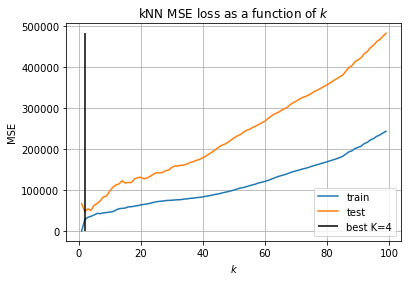

In [54]:
# MSE Loss as a function of K 
plt.plot(neighbors, train_mses, label="train"); 
plt.plot(neighbors, test_mses, label="test"); 
plt.vlines(best_k, 0, max(test_mses), color='black', label='best K=4')
plt.xlabel(r'$k$')
plt.ylabel('MSE') 
plt.title('kNN MSE loss as a function of $k$') 
plt.legend(loc = 'lower right'); 
plt.savefig("MSE Loss KNN") 
plt.grid();

In [69]:
# Fit best K KNN model and store results
best_knn = KNeighborsRegressor(n_neighbors=best_k).fit(X_train_yr, y_train) 
metrics = get_metrics(best_knn, X_train_yr, X_test_yr) 
results.append({'model': "Best KNN", 
                'train_mse': metrics['train_mse'],
                'test_mse': metrics['test_mse'],
               'train_r2': metrics['train_r2'], 
                'test_r2': metrics['test_r2'], 
                'train_accuracy': metrics['train_accuracy'], 
                'test_accuracy': metrics['test_accuracy']
               })

Intuitively, the best predictors for stock performance are the previous time stamps or time stamps with similar conditions. Hence, we built a KNN model to predict stock prices using all predictors. However, in practice, the KNN model was our worst performing model despite tuning our hyperparameters. 

#### Lasso Regularization

In [56]:
# Lasso Hyper Parameter Tuning 
alphas = [10**k for k in range(-5, 0)]
k=20
poly = PolynomialFeatures(degree=best_degree, include_bias=include_bias);
x_poly_train_lasso = poly.fit_transform(X_train_yr); 
x_poly_test_lasso = poly.transform(X_test_yr);

lasso = LassoCV(alphas=alphas, cv=k).fit(x_poly_train_lasso, y_train) 
best_alpha = lasso.alpha_
best_alpha

0.1

In [71]:
# Fit Best LASSO model using CV chosen Polynomial degree
include_bias=False
poly = PolynomialFeatures(degree=best_degree, include_bias=include_bias) 
x_poly_train_lasso = poly.fit_transform(X_train_yr) 
x_poly_test_lasso = poly.transform(X_test_yr) 
lasso_model = Lasso(alpha=best_alpha).fit(x_poly_train_lasso, y_train)

metrics = get_metrics(lasso_model, x_poly_train_lasso, x_poly_test_lasso)

results.append({'model': "Lasso", 
                'train_mse': metrics['train_mse'],
                'test_mse': metrics['test_mse'],
               'train_r2': metrics['train_r2'], 
                'test_r2': metrics['test_r2'], 
                'train_accuracy': metrics['train_accuracy'], 
                'test_accuracy': metrics['test_accuracy']
               })

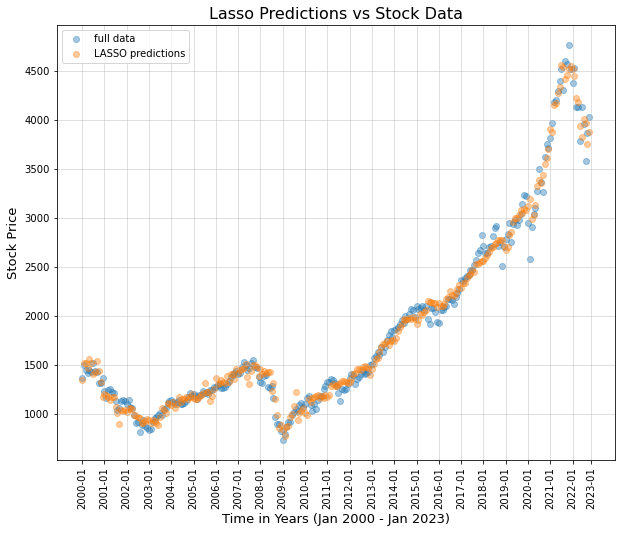

In [58]:
# LASSO Data Predictions 
X_nodt = X.drop(['Date'], axis=1)
x_poly_lasso = poly.fit_transform(X_nodt) 
lasso_model = Lasso(alpha=best_alpha).fit(x_poly_lasso, y)
lasso_pred = lasso_model.predict(x_poly_lasso) 

plt.figure(figsize=(10, 8))
plt.scatter(df['Date'], df['S&P500 price close at end of the month (^GSPC) (dollars)'], 
            label='full data', alpha=0.4)
plt.scatter(df['Date'], lasso_pred, 
            label='LASSO predictions', alpha=0.4) 
plt.legend()
plt.xlabel("Time in Years (Jan 2000 - Jan 2023)", fontsize="13") 
plt.ylabel("Stock Price", fontsize="13") 
plt.grid(alpha=0.5)
plt.xticks(x_ticks, rotation=90)
plt.title("Lasso Predictions vs Stock Data", fontsize="16");

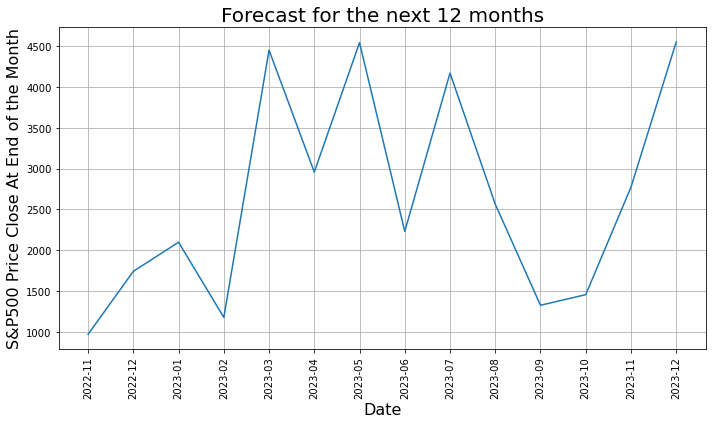

In [59]:
# Forecast of next 14 months
# Store predictions as array and create DataFrame
predictions = lasso_model.predict(x_poly_test_lasso)
predictions = pd.DataFrame({"Predictions": predictions})
predictions.to_csv("Predicted-price-data.csv")
oneyear_df = pd.DataFrame(predictions[:14])
oneyear_df.to_csv("one-year-predictions.csv")
x_ticks = ["2022-11", "2022-12", "2023-01", "2023-02", "2023-03", 
            "2023-04", "2023-05", "2023-06", "2023-07", "2023-08",
             "2023-09", "2023-10", "2023-11", "2023-12"]
oneyear_df_pred = pd.read_csv("one-year-predictions.csv")
oneyear_df_pred.drop('Unnamed: 0', axis=1, inplace=True)
oneyear_df_pred.insert(0, "Date", x_ticks, True)

f = plt.figure(figsize=(10,6))
plt.plot(oneyear_df_pred["Date"], oneyear_df_pred["Predictions"])
plt.title("Forecast for the next 12 months", fontsize=20)
plt.xlabel("Date", fontsize=16)
plt.ylabel("S&P500 Price Close At End of the Month", fontsize=16)
plt.xticks(x_ticks, rotation=90)
plt.tight_layout()
plt.grid();
plt.savefig("Lasso Forecast")

In [72]:
results = pd.DataFrame(results)
display(results)

,model,train_mse,test_mse,train_r2,test_r2,train_accuracy,test_accuracy
0,SLR,47570.176371,111554.773114,0.943110,0.911158,90.563574,88.328597
1,Best Polynomial (Degree 2),27305.334457,46749.265531,0.967345,0.962769,91.474384,91.341382
2,Best Polynomial CV (Degree 3),12881.321208,21628.594017,0.984595,0.982775,95.266215,94.481705
3,Best KNN,27177.259431,47457.135723,0.967498,0.962205,92.545542,89.413157
4,Lasso,4817.012110,19009.057899,0.994239,0.984861,96.917614,95.117896


Lastly, we found our best alpha using cross validation for LASSO regression so we can penalize non-important predictors and keep only the most important features. Additionally, economic predictors tend to be highly correlated with one another, so the LASSO model has the added benefit of reducing multicollinearity in our model. Using LASSO methods, we improved on our best polynomial degree model performance, and we used the LASSO model to forecast the next 14 months. We predict that the US will continue its downward economic spiral the following year using the S&P 500 as a proxy for the US economy. 

## Modeling Stock Price Action With Technical Analysis Models


### RSI (Relative Strength Index)
The Relative Strength Index (RSI), developed by J. Welles Wilder, is a momentum oscillator that measures the speed and change of price movements. The RSI oscillates between zero and 100. Traditionally the RSI is considered overbought when above 70 and oversold when below 30. Signals can be generated by looking for divergences and failure swings. RSI can also be used to identify the general trend.
**How RSI works**
- RSI is considered overbought when above 70 and oversold when below 30. These traditional levels can also be adjusted if necessary to better fit the security. For example, if a security is repeatedly reaching the overbought level of 70 you may want to adjust this level to 80.
    - Note: During strong trends, the RSI may remain in overbought or oversold for extended periods.
- RSI also often forms chart patterns that may not show on the underlying price chart, such as double tops and bottoms and trend lines. Also, look for support or resistance on the RSI.
- In an uptrend or bull market, the RSI tends to remain in the 40 to 90 range with the 40-50 zone acting as support. During a downtrend or bear market the RSI tends to stay between the 10 to 60 range with the 50-60 zone acting as resistance. These ranges will vary depending on the RSI settings and the strength of the security’s or market’s underlying trend.
- If underlying prices make a new high or low that isn't confirmed by the RSI, this divergence can signal a price reversal. If the RSI makes a lower high and then follows with a downside move below a previous low, a Top Swing Failure has occurred. If the RSI makes a higher low and then follows with an upside move above a previous high, a Bottom Swing Failure has occurred.
- To calculate RSI: ```RSI = 100 – [100 / ( 1 + (Average of Upward Price Change / Average of Downward Price Change ) ) ]```


### SMA (Simple Moving Average)
Moving averages are one of the core indicators in technical analysis, and there are a variety of different versions. SMA is the easiest moving average to construct. It is simply the average price over the specified period. The average is called "moving" because it is plotted on the chart bar by bar, forming a line that moves along the chart as the average value changes.
**How SMA works**
- SMAs are often used to determine trend direction. If the SMA is moving up, the trend is up. If the SMA is moving down, the trend is down. A 200-bar SMA is common proxy for the long term trend. 50-bar SMAs are typically used to gauge the intermediate trend. Shorter period SMAs can be used to determine shorter term trends.
- SMAs are commonly used to smooth price data and technical indicators. The longer the period of the SMA, the smoother the result, but the more lag that is introduced between the SMA and the source.
- Price crossing SMA is often used to trigger trading signals. When prices cross above the SMA, you might want to go long or cover short; when they cross below the SMA, you might want to go short or exit long.
- SMA Crossing SMA is another common trading signal. When a short period SMA crosses above a long period SMA, you may want to go long. You may want to go short when the short-term SMA crosses back below the long-term SMA.
- To calculate SMA, SMA is simply the ```mean```, or ```average```, of the ```stock price values over the specified period```.


### MACD (Moving Average Convergence Divergence)
The Moving Average Convergence/Divergence indicator is a momentum oscillator primarily used to trade trends. Although it is an oscillator, it is not typically used to identify over bought or oversold conditions. It appears on the chart as two lines which oscillate without boundaries. The crossover of the two lines give trading signals similar to a two moving average system.
**How MACD works**
- MACD crossing above zero is considered bullish, while crossing below zero is bearish. Secondly, when MACD turns up from below zero it is considered bullish. When it turns down from above zero it is considered bearish.
- When the MACD line crosses from below to above the signal line, the indicator is considered bullish. The further below the zero line the stronger the signal.
- When the MACD line crosses from above to below the signal line, the indicator is considered bearish. The further above the zero line the stronger the signal.
- During trading ranges the MACD will whipsaw, with the fast line crossing back and forth across the signal line. Users of the MACD generally avoid trading in this situation or close positions to reduce volatility within the portfolio.
- Divergence between the MACD and the price action is a stronger signal when it confirms the crossover signals.
- MACD can be calculated by subtracting the value of a ```26 period Exponential Moving Average (EMA) from a 12 period EMA```. The shorter EMA is constantly converging toward, and diverging away from, the longer EMA. This causes MACD to oscillate around the zero level. A signal line is created with a ```9 period EMA``` of the MACD line.

In [61]:
def plot_stock_signals(ticker, start_date, end_date):
    ''' 
    Plot stock data for specified ticker, start date and end date. Indicators include: SMA, RSI, MACD
    '''
    
    # load SPY500 data from start to end date for specified ticker.
    df = web.DataReader(ticker, "yahoo", start=start_date, end=end_date)

    # SMA (Simple Moving Average)
    df['SMA_200'] = ta.trend.sma_indicator(df['Close'], window=200)
    #df['SMA_50'] = ta.trend.sma_indicator(df['Close'], window=50)


    # RSI (Relative Strength Index)
    # over 70 = over brought, under 30 = oversold
    df['RSI-14'] = ta.momentum.rsi(df['Close'], window=14)

    # MACD (Moving Average Convergence Divergence)
    # MACD line = 12-day, EMA - 26-day, signal line = 9-day
    macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)

    # plot close price and SMA
    fig, axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 1, 1]}, figsize=(15, 10), sharex=True)
    axs[0].plot(df['Close'], label='Close Price')
    axs[0].plot(df['SMA_200'], label='SMA (200 day)')
    #axs[0].plot(df['SMA_50'], label='SMA (50 day)')
    #axs[0].plot(df['EMA_200'], label='EMA_200')
    axs[0].set_title('%s Close Price' % ticker)
    axs[0].legend()
    axs[0].grid()
    axs[0].set_ylabel('Price')
    axs[0].yaxis.set_major_formatter(FormatStrFormatter('$%d'))

    # plot RSI
    axs[1].axhline(70, color='red', linestyle='--', label='overbought (RSI 70)')
    axs[1].axhline(30, color='green', linestyle='--', label='oversold (RSI 30')
    axs[1].plot(df['RSI-14'], color='orange', label='RSI (14 day)')
    axs[1].grid()
    axs[1].set_ylabel('RSI')
    axs[1].legend()

    #plot MACD
    axs[2].plot(macd.macd(), color='blue', label='MACD (EMA 12, 26)')
    axs[2].plot(macd.macd_signal(), color='orange', label='MACD Signal (EMA 9)')
    macd_hist_color = ["red" if cl < 0 else "green" for cl in macd.macd_diff()]
    axs[2].bar(macd.macd_diff().index, macd.macd_diff(), color=macd_hist_color, label='MACD Histogram')
    axs[2].grid()
    axs[2].set_ylabel('MACD')
    axs[2].legend(loc=2)
    axs[2].set_xlabel('Date')
    plt.setp(axs[0].get_xticklabels(), visible=False)

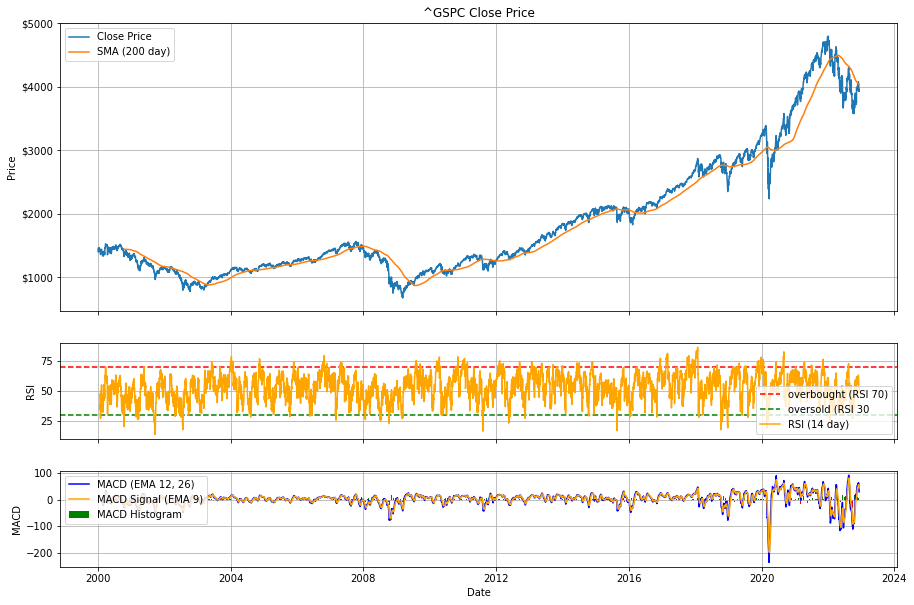

In [62]:
# plot SP500 from 2000 to today
plot_stock_signals('^GSPC', '2000-01-01', dt.datetime.now())

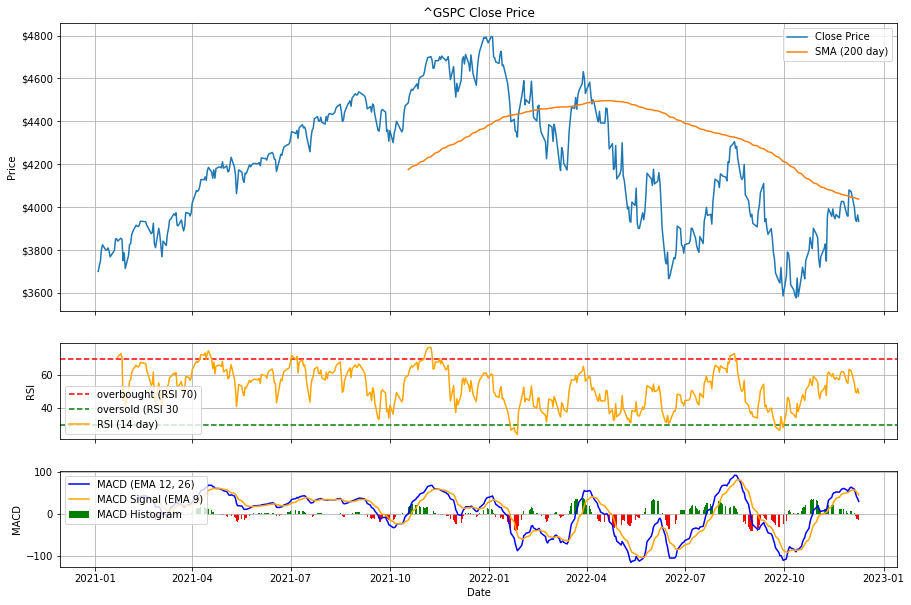

In [77]:
#plot SP500 from 2021 to today
plot_stock_signals('^GSPC', '2021-01-01', dt.datetime.now())